In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import pymc.sampling.jax as pmjax
import matplotlib.pyplot as plt
from utils import compute_points
from tqdm.auto import tqdm
import arviz as az

from src.utils import extract_all_scores, extract_posteriors, simulate_leagues
from src.models import beta_hierarchial_model, beta_hierarchial_model_cap

/home/onorevole/miniconda3/envs/pymc_5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Inspect data and choose prior

Mean:  71.43666666666667
Standard Deviation:  6.8763596635299855


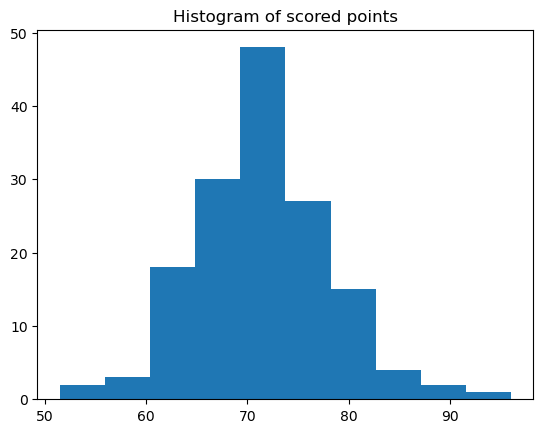

In [2]:
#read scores
df = pd.read_csv("./data/Punti.csv")
teams =  df["name"].unique()
scores = extract_all_scores(df)

#display the array as histogram
plt.hist(scores)
plt.title("Histogram of scored points")
mean = np.mean(scores)
sd = np.std(scores)
print("Mean: ", mean)
print("Standard Deviation: ", sd)


Inspect the score distibution of every individual 

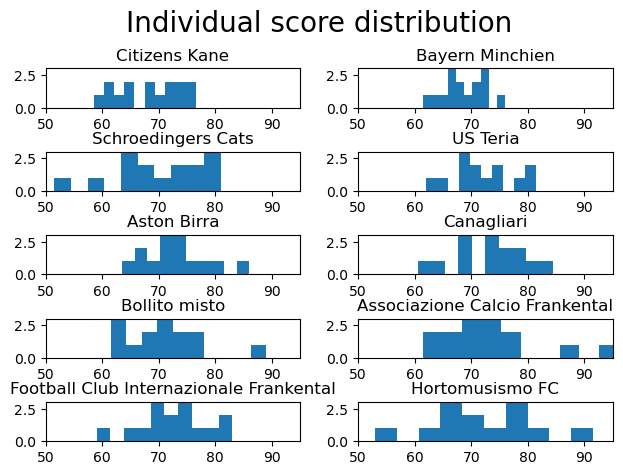

In [3]:
fig, ax = plt.subplots(5,2)
fig.tight_layout(rect=(0,0,1,0.9))
fig.suptitle("Individual score distribution", fontsize = 20)

for i,team in enumerate(teams):
    
    df_team = df.loc[df["name"] == team]
    score_team = df_team.values[0][2:-1].astype("float")
    score_team = score_team[~np.isnan(score_team)]
        
    ax[i%5,i%2].set_title(team)
    ax[i%5,i%2].set_xlim(50,95)
    ax[i%5,i%2].set_ylim(0,3)
    ax[i%5,i%2].hist(score_team)

    

Define the hierarchical model

In [4]:
model = beta_hierarchial_model_cap(df, mean, sd)

Associazione Calcio Frankental : 1 scores capped from above
[[0.58593405]
 [0.59650838]
 [0.48019076]
 [0.36387313]
 [0.46961643]
 [1.        ]
 [0.55421106]
 [0.41674478]
 [0.28985283]
 [0.54363673]
 [0.48019076]
 [0.31100149]
 [0.8185693 ]
 [0.48019076]
 [0.52248807]]


Prior predictive checks

Sampling: [Exp_alpha_Citizens Kane, Exp_beta_Citizens Kane, lambda_hp, normalized_score_Citizens Kane]


Text(0.5, 1.0, 'Prior check')

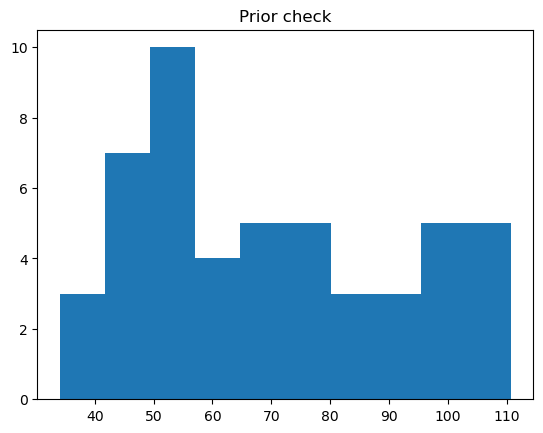

In [5]:
i_data = pm.sample_prior_predictive(samples=50, model=model,
                                    var_names=["score_Citizens Kane"])

plt.hist(i_data["prior"]["score_Citizens Kane"].values[0,:,0])
plt.title("Prior check")

#note that the prior should be independent on the chosen team
#prior seems reasonable

Sample

In [6]:
with model:
    trace = pmjax.sample_blackjax_nuts(draws=1000, tune=1000,
                                            chains=4, target_accept=0.8)

Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:11.358013
Sampling...
Sampling time =  0:00:38.072759
Transforming variables...
Transformation time =  0:00:02.406444


<Axes: >

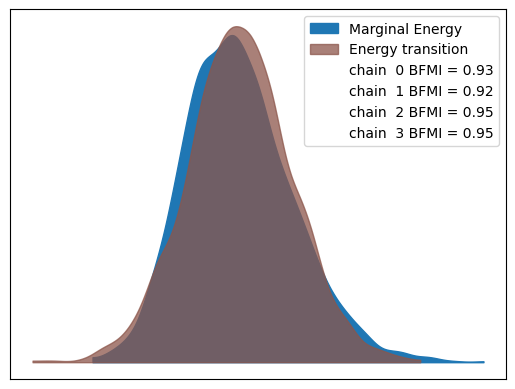

In [7]:
az.plot_energy(trace)

Inspect the posterior

Sampling: [normalized_score_Citizens Kane]


Sampling: [normalized_score_US Teria]


Sampling: [normalized_score_Aston Birra]


Sampling: [normalized_score_Associazione Calcio Frankental]


Sampling: [normalized_score_Football Club Internazionale Frankental]


Sampling: [normalized_score_Bayern Minchien]


Sampling: [normalized_score_Schroedingers Cats]


Sampling: [normalized_score_Canagliari]


Sampling: [normalized_score_Bollito misto]


Sampling: [normalized_score_Hortomusismo FC]


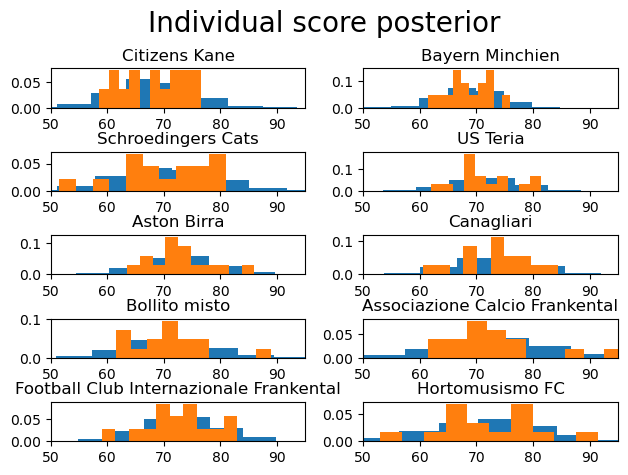

In [8]:
fig, ax = plt.subplots(5,2)
fig.tight_layout(rect=(0,0,1,0.9))
fig.suptitle("Individual score posterior", fontsize = 20)

for i,team in enumerate(teams):
    
    posterior = pm.sample_posterior_predictive(trace, model, [f"score_{team}"])
    posterior = posterior.posterior_predictive[f"score_{team}"].values.ravel()
    
    df_team = df.loc[df["name"] == team]
    score_team = df_team.values[0][2:-1].astype("float")
    score_team = score_team[~np.isnan(score_team)]
    
    ax[i%5,i%2].set_title(team)
    ax[i%5,i%2].set_xlim(50,95)
    ax[i%5,i%2].hist(posterior, density=True)
    ax[i%5,i%2].hist(score_team,density=True)

Simulate the remaining part of the league

In [9]:
pars = {
        "num_league_simulation": 10000,
        "last_played_match_day": 15,
        "total_match_day": 36,
        "current_standing": {'Citizens Kane': 17,
                            'US Teria': 16,
                            'Aston Birra': 23,
                            'Associazione Calcio Frankental': 22,
                            'Football Club Internazionale Frankental': 19,
                            'Bayern Minchien': 17,
                            'Schroedingers Cats': 30,
                            'Canagliari': 24,
                            'Bollito misto': 15,
                            'Hortomusismo FC': 29}
}


#sample from the posterior
team_scores = extract_posteriors(trace, model, teams)

Sampling: [normalized_score_Citizens Kane]


Sampling: [normalized_score_US Teria]


Sampling: [normalized_score_Aston Birra]


Sampling: [normalized_score_Associazione Calcio Frankental]


Sampling: [normalized_score_Football Club Internazionale Frankental]


Sampling: [normalized_score_Bayern Minchien]


Sampling: [normalized_score_Schroedingers Cats]


Sampling: [normalized_score_Canagliari]


Sampling: [normalized_score_Bollito misto]


Sampling: [normalized_score_Hortomusismo FC]


In [10]:
df_calendar = pd.read_csv("./data/Calendario_Campionato.csv")
df_calendar = df_calendar.loc[df_calendar["giornata"].astype(int) > pars["last_played_match_day"]]

results = simulate_leagues(df_calendar, teams, pars, team_scores)                         
        

100%|██████████| 10000/10000 [02:26<00:00, 68.23it/s]


Plot the results of the simulation

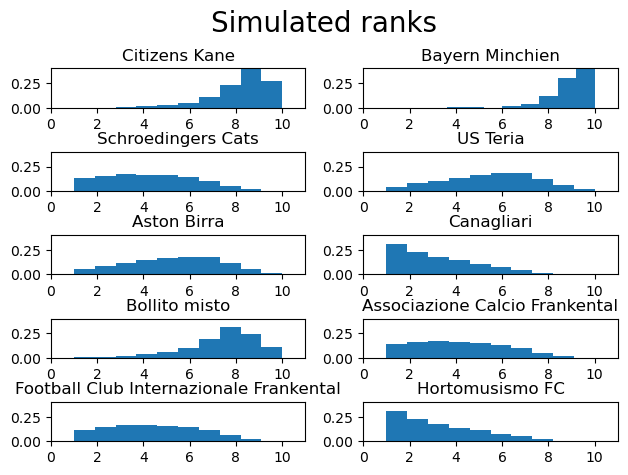

In [11]:
fig, ax = plt.subplots(5,2)
fig.tight_layout(rect=(0,0,1,0.9))
fig.suptitle("Simulated ranks", fontsize = 20)

for i,team in enumerate(teams):
    
    ax[i%5,i%2].set_title(team)
    ax[i%5,i%2].set_xlim(0,11)
    ax[i%5,i%2].set_ylim(0,0.4)    
    ax[i%5,i%2].hist(results[team], density=True, bins=10)
    